# Regularization

In these notes, we will investigate the use of **regularization** methods, specifically *ridge regression* and the *lasso*, for supervised learning.

- [Ridge Regression | `sklearn` User Guide](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification)
- [Lasso | `sklearn` User Guide](https://scikit-learn.org/stable/modules/linear_model.html#lasso)

In [1]:
# general imports
import numpy as np
import pandas as pd

# data generation and loading
from sklearn.datasets import make_regression
from sklearn.datasets import make_blobs
from sklearn.datasets import load_diabetes

# plotting
import matplotlib.pyplot as plt
import matplotlib.colors

# linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

# model tuning and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# model metrics
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score

In [2]:
#  helper function to visualize regularization paths
def plot_regularization_path(type="ridge"):

    # generate some data
    X = 1.0 / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
    y = np.ones(10)
    X, y = load_diabetes(return_X_y=True)

    # choose alpha values
    n_alphas = 100
    alphas = np.logspace(-5, 2, n_alphas)

    # setup container for learned coefficients
    coefs = []

    # learn coefficients
    for a in alphas:
        if type == "ridge":
            mod = Ridge(alpha=a, fit_intercept=True)
        if type == "lasso":
            mod = Lasso(alpha=a, fit_intercept=True)
        mod.fit(X, y)
        coefs.append(mod.coef_)

    # plot path
    _, ax = plt.subplots()
    ax.plot(alphas, coefs)
    ax.set_xscale("log")
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_xlabel("$\\lambda$")
    ax.set_ylabel("Coefficients")
    if type == "ridge":
        ax.set_title("Ridge Regularization Path")
    if type == "lasso":
        ax.set_title("Lasso Regularization Path")
    ax.axis("tight")
    ax.grid(
        color="lightgrey",
        linestyle="--",
        zorder=0,
    )

In [3]:
def simulate_slr(b0, b1, sigma, n, seed=42):
    np.random.seed(seed)
    x = np.random.rand(n)
    X = x.reshape(n, 1)
    e = np.random.normal(0, sigma, n)
    y = b0 + b1 * x + e
    return X, y


def visualize_slr_data(X, y):
    _, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(X, y, color="darkgrey", zorder=2)
    x = np.linspace(0, 1, 100)
    colors = ["tab:blue", "tab:orange", "tab:green"]
    alphas = [0.0, 0.25, 0.5]
    for alpha, color in zip(alphas, colors):
        if alpha == 0:
            mod = LinearRegression().fit(X, y)
        else:
            mod = Lasso(alpha=alpha).fit(X, y)
        b0 = mod.intercept_
        b1 = mod.coef_[0]
        y_pred = b0 + b1 * x
        ax.plot(
            x,
            y_pred,
            color=color,
            label=f"$\\lambda = {alpha}$",
            zorder=3,
        )
    ax.set_xlim(0, 1)
    ax.set_ylim(-2, 8)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_title("Simulated Regression Data | Penalized Regressions")
    ax.legend()
    ax.grid(
        color="lightgrey",
        linestyle="--",
        zorder=0,
    )
    plt.show()

## Main Idea

Consider the **objective function** for *simple* linear regression.

$$
L(\beta_0, \beta_1) = \sum_{i=1}^{n} \left( y_i - \beta_0 - \beta_1 x_{i} \right) ^ 2
$$

We could also call this function the squared-error **loss function**.

Recall that the goal is to *minimize* this function with respect to $\beta_0$ and $\beta_1$. After performing that optimization, we obtain $\hat{\beta}_0$ and $\hat{\beta}_1$, and thus would make predictions using:

$$
\hat{f}(x) = \hat{\beta}_0 + \hat{\beta}_0 x.
$$

Now suppose that we modify the objective function by adding a new term.

$$
\sum_{i=1}^{n} \left( y_i - \beta_0 - \beta_1 x_{i} \right) ^ 2 + \lambda |\beta_1|
$$

This new objective function contains the usual squared error loss, but also the new term. This new term has two elements. First $\lambda$, which we will consider a **tuning parameter**, as well as $|\beta_1|$, which we will describe as a **penalty**.

$$
\textcolor{teal}{\underbrace{\sum_{i=1}^{n} \left( y_i - \beta_0 - \beta_1 x_{i} \right) ^ 2}_{\text{Loss}}} + 
\lambda \textcolor{purple}{\underbrace{ |\beta_1|}_{\text{Penalty}}}
$$

Our goal is still to minimize this objective function.

$$
\min_{\beta_0, \beta_1} \left\{ \sum_{i=1}^{n} \left( y_i - \beta_0 - \beta_1 x_{i} \right) ^ 2 + \lambda |\beta_1| \right\}
$$

However, now the *loss* and the *penalty* are working against each other.

- To fit data well, $\beta_1$ will often need to be "large" in magnitude. Doing so helps minimize the loss portion, which keeps the overall objective function small.
- But to keep the penalty small, which keeps the overall objective small, $|\beta_1|$ needs to be small.

You might be wondering *why* we would do this. Frankly, in this case, it would be a silly thing to do! But this silly example will illustrate *what* adding a penalty does, before we move to serious and useful applications of added penalty terms.

In short, the added penalty will **increase bias**, but **decrease variance**. In this simple case, the increased bias (squared) will likely be larger than the decrease in variance, thus will have an overall negative effect on model performance. But in certain situations, the increased bias will cause enough of a variance reduction to have a positive effect on model performance.

Let's fit this model to some simple data.

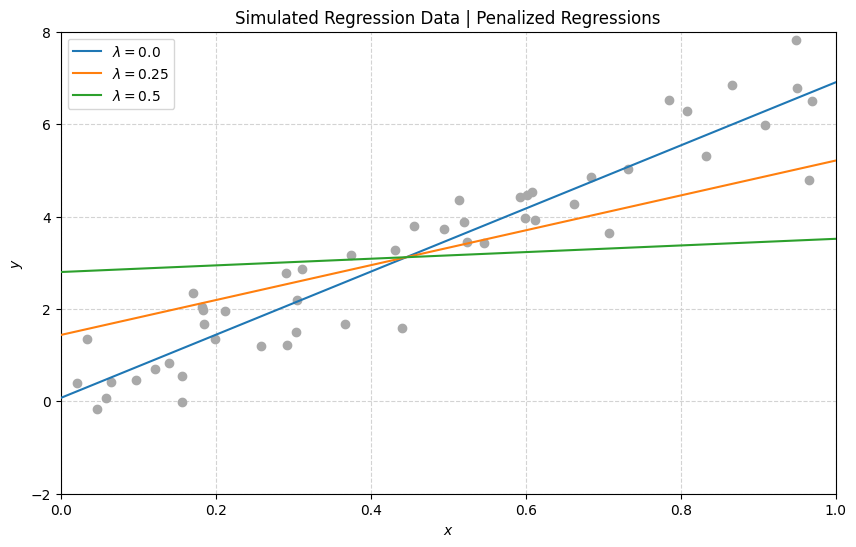

In [4]:
X, y = simulate_slr(0, 7, 0.75, 50, seed=42)
visualize_slr_data(X, y)

Here, we have fit this modified *penalized* simple linear regression model to some data, but with three different values of the tuning parameter $\lambda$.

- When $\lambda = 0$, no penalty is applied, and thus we are fitting the usual simple linear regression, which in this case, works well.
- When $\lambda = 0.25$, we have added some penalty. Notice that with $\lambda = 0.25$, the slope of the learned regression, $\hat{\beta}_1$, is less than the un-penalized regression when $\lambda = 0$. As a result, this model does not fit as well.
- When $\lambda = 0.5$, we have further increased the penalty. The learned slope is again smaller, resulting in even worse performance.

While this added penalty term has clearly deteriorated performance, for now it is more important to understand how it effects bias and variance. As the tuning parameter $\lambda$ is increased, the penalty term has a greater effect, in this case limiting the potential magnitude of the slope. Thus, we have **increased bias** and **decreased variance**.

Purposefully restricting the ability of a model to learn as a general concept is called **regularization**. Regularization can take one of two forms:

- **Explicit Regularization**: Using a penalty term to directly limit learning during optimization.
- **Implicit Regularization**: Any other modification to a model fitting procedure that can limit learning. For example, the `max_samples` parameter for Random Forests in `sklearn` is a form of implicit regularization. By limiting the number of observations used to fit each tree in the forest, we are suppressing the ability of the trees to learn.

While at face value it may seem counter productive to limit learning, when dealing with methods that can very easily learn the training data, and thus are prone to overfitting, regularization can dramatically increase generalization performance. Regularization plays an important role in the application of deep learning models.

There are many forms of regularization. We will focus on two variants that are modifications of linear regression.

- **Ridge Regression**
- **Lasso**

Both are highly effective when modeling a *large number of feature variables*. Unlike un-penalized regression, they can be used when $p > n$, that is the number of features is greater than the number of samples!

Relevant documentation:

- [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
- [`sklearn.linear_model.Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
- [`sklearn.linear_model.Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

## Ridge Regression

First, recall the loss function for multiple linear regression.

$$
L(\boldsymbol{\beta}) = \sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right) ^ 2
$$

Recall that $n$ is the number of samples, $p$ is the number of features, and $x_{ij}$ is the $i$-th observation of the $j$-th feature.

**Ridge Regression** adds the so-called $L_2$ ("el two") penalty.

$$
\textcolor{teal}{\underbrace{\sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right) ^ 2}_{\text{Loss}}} + \lambda \textcolor{purple}{\underbrace{\sum_{j=1}^{p} \beta_j^2}_{\text{Penalty}}} 
$$

Like before, $\lambda$ is a tuning parameter that controls the size of the effect of the penalty.

- When $\lambda = 0$, ridge regression is equivalent to ordinary linear regression.
- When $\lambda = \infty$, each $\beta$ coefficient is set to 0 except for the intercept. Note that the intercept $\beta_0$ is not included in the penalty.

When $\lambda$ is set between $0$ and $\infty$, we generally expect to see learned $\beta$ coefficients (except for the intercept) that are *smaller* (in magnitude) than those learned by ordinary linear regression.

Let's look at an example.

### Example

Recall the diabetes data from `sklearn`.

- [Diabetes | `sklearn` Datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset)

In [5]:
# load diabetes data from sklearn
diabetes = load_diabetes(as_frame=True).frame

# train-test split the data
diabetes_train, diabetes_test = train_test_split(
    diabetes,
    test_size=0.2,
    random_state=42,
)

# create the X and y version of the train data
X_train = diabetes_train.drop("target", axis=1)
y_train = diabetes_train["target"]

# create the X and y version of the test data
X_test = diabetes_test.drop("target", axis=1)
y_test = diabetes_test["target"]

# check shapes of data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((353, 10), (353,), (89, 10), (89,))

In [6]:
X_train.head().map("{:.3f}".format)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
17,0.071,0.051,0.012,0.056,0.034,0.049,-0.040,0.034,0.027,-0.001
66,-0.009,0.051,-0.018,-0.033,-0.021,0.012,-0.073,0.071,0.000,0.020
137,0.005,-0.045,0.050,0.098,-0.015,-0.016,-0.007,-0.003,0.017,-0.014
245,-0.027,-0.045,-0.035,-0.030,-0.057,-0.059,0.030,-0.039,-0.050,-0.129
31,-0.024,-0.045,-0.065,-0.081,-0.039,-0.054,0.060,-0.076,-0.037,-0.042


Notice that these features are already scaled! By default, the `load_diabetes()` applies scaling. This is an important detail that we will return to later.

In [7]:
y_train

17     144.0
66     150.0
137    280.0
245    125.0
31      59.0
       ...  
106    134.0
270    202.0
348    148.0
435     64.0
102    302.0
Name: target, Length: 353, dtype: float64

In [8]:
linear = LinearRegression()
_ = linear.fit(X_train, y_train)

ridge = Ridge(alpha=0.1)
_ = ridge.fit(X_train, y_train)

Here we fit the usual linear regression, as well as ridge regression. Note that `sklearn` uses `alpha` instead of $\lambda$. This is necessary because `lambda` is a reserved word in Python which is used for [lambda functions](https://realpython.com/python-lambda/).

For now, we're setting an arbitrary values of `alpha` to at least apply some regularization. Later, we will discuss tuning this parameter.

In [9]:
print(linear.coef_)

[  37.90402135 -241.96436231  542.42875852  347.70384391 -931.48884588
  518.06227698  163.41998299  275.31790158  736.1988589    48.67065743]


In [10]:
print(ridge.coef_)

[  42.85566976 -205.49431899  505.08903304  317.0932049  -108.50026183
  -86.23673333 -190.36318008  151.70708637  392.28931896   79.9081772 ]


Comparing the estimated coefficients of the two models, what do you notice? When comparing the coefficients, we only care about their magnitude.

While it is not uniformly true, notice that the coefficients for the ridge regression are often small in magnitude. This phenomenon is called _**shrinkage**_. By applying regularization, we have *shrunk* the estimated coefficients.

In [11]:
np.abs(ridge.coef_) / np.abs(linear.coef_)

array([1.13063649, 0.84927515, 0.93116197, 0.91196347, 0.11648047,
       0.16646017, 1.16487088, 0.55102514, 0.53285782, 1.64181421])

Here, we've calculated the the relative magnitudes of the two sets of coefficients. Note that the ridge coefficients are often small, and sometimes much smaller. Rather than compared each individual coefficient, we could instead consider the overall effect of the regularization, by comparing the ridge penalty term of both models.

In [12]:
np.sum(np.abs(ridge.coef_)) / np.sum(np.abs(linear.coef_))

0.541100877838992

We see that overall the ridge regression coefficients are a much smaller than the un-penalized regression.

What effect does this have on performance?

In [13]:
rmse_linear = root_mean_squared_error(y_test, linear.predict(X_test))
rmse_ridge = root_mean_squared_error(y_test, ridge.predict(X_test))

In [14]:
print(f"Test RMSE for Linear Regression: {rmse_linear:.2f}")
print(f"Test RMSE for Ridge Regression: {rmse_ridge:.2f}")

Test RMSE for Linear Regression: 53.85
Test RMSE for Ridge Regression: 53.45


Here we see a very modest improvement by using ridge regression. However, the difference is likely not meaningful. Additionally, we have not bothered to tune the `alpha` parameter, and this example is not a situation where we would expect regularization to shine.

## Lasso

The lasso is similar to ridge regression, but modifies the penalty term. Where ridge considers the squares of the coefficients, lasso uses an absolute value.

$$
\textcolor{teal}{\underbrace{\sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right) ^ 2}_{\text{Loss}}} + \lambda \textcolor{purple}{\underbrace{\sum_{j=1}^{p} |\beta_j|}_{\text{Penalty}}} 
$$



What effect does this have? Let's repeat the process above, but with the lasso.

In [15]:
linear = LinearRegression()
_ = linear.fit(X_train, y_train)

lasso = Lasso(alpha=0.1)
_ = lasso.fit(X_train, y_train)

In [16]:
print(linear.coef_)

[  37.90402135 -241.96436231  542.42875852  347.70384391 -931.48884588
  518.06227698  163.41998299  275.31790158  736.1988589    48.67065743]


In [17]:
print(lasso.coef_)

[   0.         -152.66477923  552.69777529  303.36515791  -81.36500664
   -0.         -229.25577639    0.          447.91952518   29.64261704]


*Wow!* That is quite different than both linear regression and ridge regression. Note only are many of the coefficients smaller, _some of them are **zero**_. When a model sets many parameters to zero, and thus has a limited number of non-zero coefficients, we call the resulting model **sparse**.

Like ridge, adding regularization via the lasso can have performance benefits, but lasso has this additional benefit: implicit *feature selection*. Setting the coefficient to zero for some features effectively removes them from the model.

In [18]:
rmse_linear = root_mean_squared_error(y_test, linear.predict(X_test))
rmse_lasso = root_mean_squared_error(y_test, lasso.predict(X_test))

In [19]:
print(f"Test RMSE for Linear Regression: {rmse_linear:.2f}")
print(f"Test RMSE for Ridge Regression: {rmse_ridge:.2f}")

Test RMSE for Linear Regression: 53.85
Test RMSE for Ridge Regression: 53.45


Here we see similar performance to ridge, but again, we have yet to give these regularized regression an opportunity to really shine.

## Feature Scaling

Because of the way the penalty terms are calculated, together with how scaling affects coefficient estimates, feature scaling is an important consideration with using ridge and lasso models.

Using ridge, let's reconsider the `diabetes` data, but with both scaled and then unscaled features.

In [20]:
diabetes_scaled = load_diabetes(as_frame=True, scaled=True).frame
diabetes_unscaled = load_diabetes(as_frame=True, scaled=False).frame

In [21]:
# train-test split the data
diabetes_train, diabetes_test = train_test_split(
    diabetes_scaled,
    test_size=0.2,
    random_state=42,
)

# create the X and y version of the train data
X_train = diabetes_train.drop("target", axis=1)
y_train = diabetes_train["target"]

# create the X and y version of the test data
X_test = diabetes_test.drop("target", axis=1)
y_test = diabetes_test["target"]

# fit ridge regression
ridge = Ridge(alpha=1)
_ = ridge.fit(X_train, y_train)

# check coefficients
print(ridge.coef_)

# evaluate performance
rmse_ridge = root_mean_squared_error(y_test, ridge.predict(X_test))
print(f"Test RMSE for Ridge Regression: {rmse_ridge:.2f}")

[  45.36737726  -76.66608563  291.33883165  198.99581745   -0.53030959
  -28.57704987 -144.51190505  119.26006559  230.22160832  112.14983004]
Test RMSE for Ridge Regression: 55.47


In [22]:
# train-test split the data
diabetes_train, diabetes_test = train_test_split(
    diabetes_unscaled,
    test_size=0.2,
    random_state=42,
)

# create the X and y version of the train data
X_train = diabetes_train.drop("target", axis=1)
y_train = diabetes_train["target"]

# create the X and y version of the test data
X_test = diabetes_test.drop("target", axis=1)
y_test = diabetes_test["target"]

# fit ridge regression
ridge = Ridge(alpha=1)
_ = ridge.fit(X_train, y_train)

# check coefficients
print(ridge.coef_)

# evaluate performance
rmse_ridge = root_mean_squared_error(y_test, ridge.predict(X_test))
print(f"Test RMSE for Ridge Regression: {rmse_ridge:.2f}")

[  0.14269511 -22.80861461   5.90541998   1.19867986  -1.07900835
   0.62662466   0.3774738    9.77013169  60.79394666   0.21396887]
Test RMSE for Ridge Regression: 53.88


Two things to notice:

- Scaling changes the values of the estimated coefficients, quite drastically.
- Scaling impacts performance. The impact is not particularly significant here, but in some situations the difference can be important.

*Why* does this happen? The scale of a feature impacts the magnitude of the coefficients. Because the magnitude of the coefficients contribute to the ridge and lasso penalties, the scale of the features will impact the learned model, and thus its predictions. For ordinary linear regression, scaling impacts the coefficients, *but not predictions*.

We've already demonstrated the impact of scaling on ridge (and thus also lasso), but let's verify the claim about ordinary linear regression.

In [23]:
X_train, y_train = make_regression(
    n_samples=50,
    n_features=1,
    n_informative=1,
    noise=0.25,
    random_state=42,
)

By default, `make_regression()` returns pre-scaled features with mean zero and variance one.

In [24]:
linear_scaled = LinearRegression().fit(X_train, y_train)

We can then create alternative train data that we scale.

In [25]:
X_train_unscaled = 5 * X_train - 10
linear_unscaled = LinearRegression().fit(X_train_unscaled, y_train)

In [26]:
linear_scaled.coef_, linear_unscaled.coef_

(array([14.1260526]), array([2.82521052]))

As expected, these models produce different coefficients.

In [27]:
print(linear_scaled.predict(X_train[:5]))

[ -4.08028103 -26.98689715   4.47927457   7.70443194  22.34824352]


In [28]:
print(linear_unscaled.predict(X_train_unscaled[:5]))

[ -4.08028103 -26.98689715   4.47927457   7.70443194  22.34824352]


But it seems their predictions are the same! We can verify this for all observations in the train data as well.

In [29]:
np.allclose(
    linear_scaled.predict(X_train),
    linear_unscaled.predict(X_train_unscaled),
)

True

So in practice, while scaling has no impact on the *predictions* made by ordinary linear regression, scaling does impact both coefficients and *predictions* for ridge and lasso. Thus, scaling of features should always be considered for ridge and lasso.

For categorical features, one-hot-encoding should be sufficient, as one-hot-encoded features are roughly on a similar scale to scaled numeric features.

## Tuning

To investigate tuning of these models, we'll simulate some data. Note that we are simulating this data with a large number of features, but still $p < n$ so that we can compare to ordinary linear regression. However recall that ridge and lasso can be used when $p > n$, but ordinary linear regression cannot.

Notice that we are setting the `n_informative` parameter to `make_regression` to be `10`. This means that of the `400` features we are simulating, only `10` truly have an impact on the target, and thus should have a non-zero coefficient. Because we have setup a situation that calls for a *sparse* model, you might be able to guess which of ridge and lasso perform better.

In [30]:
X_train, y_train = make_regression(
    n_samples=500,
    n_features=400,
    n_informative=10,
    noise=0.25,
    random_state=42,
)
X_test, y_test = make_regression(
    n_samples=500,
    n_features=400,
    n_informative=10,
    noise=0.25,
    random_state=42,
)

When considering possible values of `alpha`, note that it is most useful to consider `alpha` values across various [orders of magnitude](https://en.wikipedia.org/wiki/Order_of_magnitude). Using `alpha` of `0.1` and `0.2` is unlikely to produce significantly different models, especially with respect to performance. In contrast, considering `0.01` and `0.1` will likely produce meaningful differences.

A somewhat standard practice is to consider several [powers of ten](https://www.youtube.com/watch?v=0fKBhvDjuy0). In addition to the default `alpha` of `1`, the next smallest power of 10, `0.1`, is generally a good candidate.

Thankfully, `numpy` can quickly produce sequences of powers of ten.

In [31]:
# produce a sequence of integers to be used as powers
np.arange(-4, 3)

array([-4, -3, -2, -1,  0,  1,  2])

In [32]:
# generating powers of 10
10.0 ** np.arange(-4, 3)

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [33]:
# define a pipeline
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LinearRegression()),
    ]
)

# define parameter grid
param_grid = [
    {
        "model": [LinearRegression()],
    },
    {
        "model": [Ridge()],
        "model__alpha": 10.0 ** np.arange(-5, 2),
    },
    {
        "model": [Lasso()],
        "model__alpha": 10.0 ** np.arange(-5, 2),
    },
]

Here, we've setup a pipeline, first to scale the features, then to fit one of linear regression, ridge regression, or a lasso model. For both the ridge and lasso models, we search through various values for `alpha` that are spread across several orders of magnitude.

While we only consider scaled features here, you certainly *could* consider unscaled features as well. Like KNN, while scaling will *probably* increase performance, there is no guarantee that this is the case.

In [34]:
# setup search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
)

# perform search
grid_search.fit(X_train, y_train)

# print results
print(
    "Best parameters found:",
    grid_search.best_params_,
)
print(
    "Best cross-validation score:",
    -grid_search.best_score_,
)

Best parameters found: {'model': Lasso(), 'model__alpha': 0.01}
Best cross-validation score: 0.07671428981302919


Given the setup, it is not too surprising that one of the regularized methods is selected. But let's take a closer look at the results of the cross-validated grid search.

In [35]:
# extract the full cross-validation results
results = grid_search.cv_results_

# get model type and alpha values for each model
model_type = []
alphas = []
for params in results["params"]:
    model_type.append(params["model"].__class__.__name__)
    alphas.append(params.get("model__alpha", "N/A"))

# arrange results as a frame
results_df = pd.DataFrame(
    {
        "Model Type": model_type,
        "Alpha": alphas,
        "Mean RMSE": -results["mean_test_score"],
        "Std RMSE": results["std_test_score"],
    }
)

# apply formatting for better printing
results_df["Mean RMSE"] = results_df["Mean RMSE"].map("{:.3f}".format)
results_df["Std RMSE"] = results_df["Std RMSE"].map("{:.3f}".format)


# display the results
results_df

,Model Type,Alpha,Mean RMSE,Std RMSE
0,LinearRegression,N/A,237.112,334.613
1,Ridge,0.00001,209.949,300.441
2,Ridge,0.0001,206.583,300.736
3,Ridge,0.001,195.033,302.700
4,Ridge,0.01,214.542,299.760
5,Ridge,0.1,389.482,321.027
6,Ridge,1.0,1023.857,459.349
7,Ridge,10.0,2961.821,594.949
8,Lasso,0.00001,1162.348,386.880
9,Lasso,0.0001,1126.673,382.355


A few things to notice here:

- Compared to the linear regression, both ridge and lasso obtain better results among some of the models considered.
- Lasso generally outperforms ridge. In this case, that is not at all surprising because of the sparsity we imposed when simulating the data.
- The results are significantly different within the lasso models (and ridge) for the values of `alpha` we have considered. Within both lasso and ridge, we can see the expected U-shaped validation curve, which implies that we have considered "enough" values of `alpha`.
- Within the lasso models, you *could* refine the search, perhaps between `0.001` and `1.0`, considering a finer grid within those values of `alpha`. This is unlikely to obtain wildly difference results, but if small performance gains could be impactful, it is something to consider.

## $L_1$ versus $L_2$ Regularization

This material is outside of the scope of CS 307, and will be completed at a later time.

- TODO: Complete this section.

Ridge regression (using $L_2$ regularization) and the lasso (using $L_1$ regularization) are similar in that they apply a penalty to the usual squared error loss. By applying a penalty, they both *shrink* the usual estimates of the coefficients. However, because of the difference in their penalty terms, they will of course produce different results. Specifically, the lasso has the unique property that it has a tendency to shrink some parameter estimates to zero. This property is rather useful, as it is an implicit form of *feature selection*.

*Why* does the lasso shrink some parameter estimates to zero? The following visualization attempts to explain.

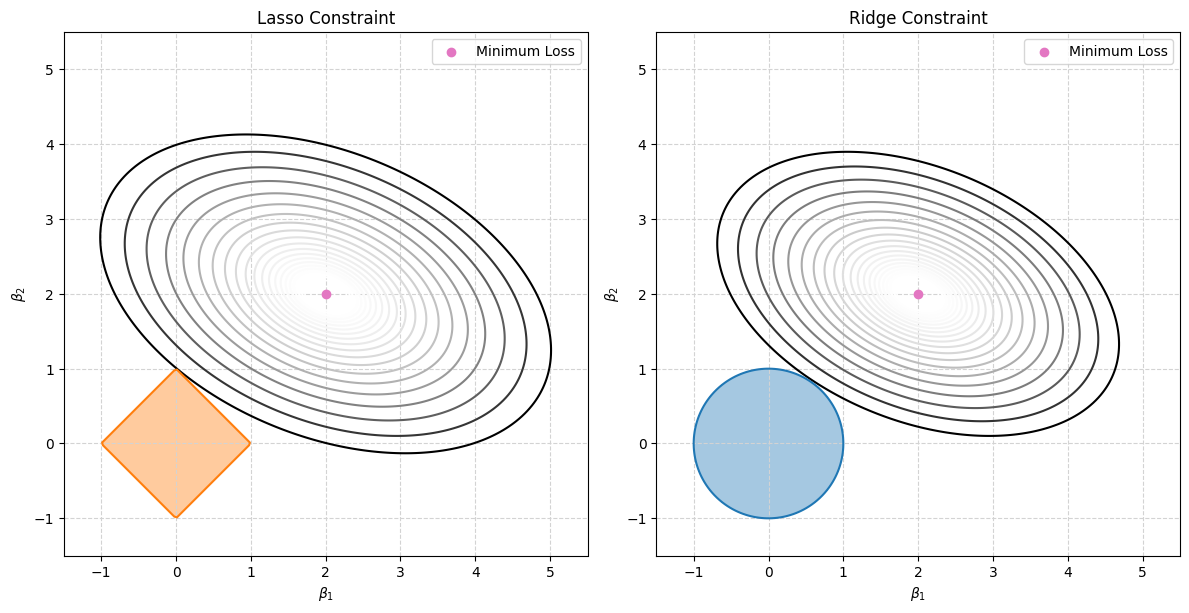

In [36]:
# create grid of potential coefficient values
b1, b2 = np.meshgrid(
    np.linspace(-1.5, 5.5, 200),
    np.linspace(-1.5, 5.5, 200),
)

# create contours of loss
rho = 0.5
loss = (b1 - 2) ** 2 + 2 * (b2 - 2) ** 2 + 2 * rho * (b1 - 2) * (b2 - 2)

# L1 norm for lasso
lasso_constraint = np.abs(b1) + np.abs(b2)

# L2 norm for ridge
ridge_constraint = np.sqrt(b1**2 + b2**2)

# setup plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# plot lasso
ax[0].contour(
    b1,
    b2,
    loss,
    levels=np.logspace(-1, 0.9, 20),
    cmap="binary",
)
ax[0].contour(
    b1,
    b2,
    lasso_constraint,
    levels=[1],
    colors="tab:orange",
)
ax[0].contourf(
    b1,
    b2,
    lasso_constraint,
    levels=[0, 1],
    colors="tab:orange",
    alpha=0.4,
)
ax[0].scatter(
    2,
    2,
    color="tab:pink",
    label="Minimum Loss",
    zorder=2,
)
ax[0].set_title("Lasso Constraint")

# plot ridge
ax[1].contour(
    b1,
    b2,
    loss,
    levels=np.logspace(-1, 0.8, 20),
    cmap="binary",
)
ax[1].contour(
    b1,
    b2,
    ridge_constraint,
    levels=[1],
    colors="tab:blue",
)
ax[1].contourf(
    b1,
    b2,
    ridge_constraint,
    levels=[0, 1],
    colors="tab:blue",
    alpha=0.4,
)
ax[1].scatter(
    2,
    2,
    color="tab:pink",
    label="Minimum Loss",
    zorder=2,
)
ax[1].set_title("Ridge Constraint")

# add labels and formatting
for a in ax:
    a.set_xlabel(r"$\beta_1$")
    a.set_ylabel(r"$\beta_2$")
    a.set_aspect("equal")
    a.legend()
    a.grid(
        color="lightgrey",
        linestyle="--",
        zorder=0,
    )

# show plot
plt.tight_layout()
plt.show()

First, we need to explain an alternative formulation of these techniques.

- ...

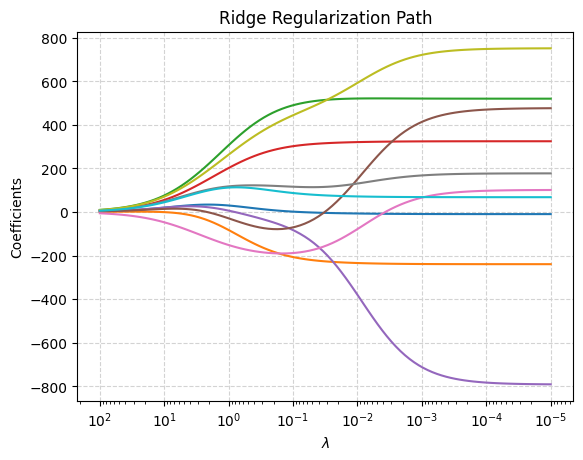

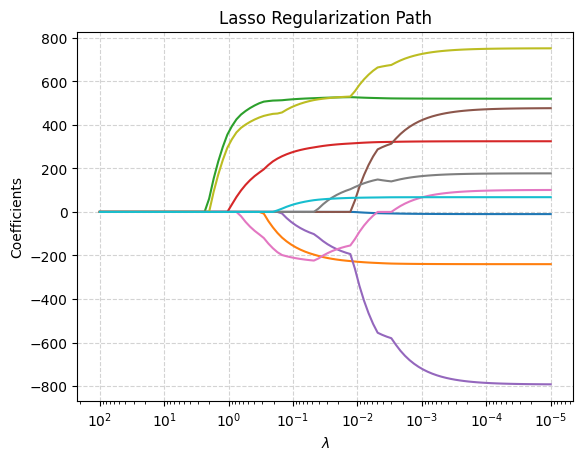

In [37]:
plot_regularization_path(type="ridge")
plot_regularization_path(type="lasso")

## Penalized Logistic Regression

So far we've added a penalty term to linear regression for a numeric response. What about a categorical response? Logistic regression is a linear model, right? So surely we can add regularization to logistic regression. You betcha!

We will skip the details, but in general, the concept is roughly the same. Apply a penalty to the **logistic loss**, which will impact the optimization and thus learned coefficients. Like linear regression, we can use either $L_2$ regularization (ridge style) or $L_1$ regularization (lasso style). Like the lasso for linear regression, adding $L_1$ regularization to logistic regression will return a potentially sparse solution, that is, setting several coefficients to zero.

In `sklearn`, `LogisticRegression()` actually applies regularization by default!

- [`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Notice the `penalty` parameter with a default of `l2`. That means, by default, `LogisticRegression()` applies an $L_2$ penalty!

Instead of `alpha`, `LogisticRegression()` uses `C`, which is related to the inverse of the regularization strength. Specifically, they are related by `alpha = 1 / (2C)`. Like `alpha`, when tuning, you will want to consider different orders of magnitude.

Because of the differences in optimization between linear and logistic regression, for logistic, we need to pay some attention to the optimization procedure used. Thankfully, we still don't need to write the optimization procedure. However, we'll need to pay close attention to the warning about solver in the documentation for the `penalty` parameter. The documentation for the `solver` parameter details which solver should be used in which situation, which depends on the penalty, and whether or not the target is binary.

Like linear regression, scaling has similar impacts on penalized logistic regression, and thus should be considered.

The following example will demonstrate tuning a logistic regression considering both $L_1$ and $L_2$ penalties. Note that to set potential values for `C`, we use the inverse of our approach to specifying `alpha` previously.

In [38]:
# simulate data
X, y = make_blobs(
    centers=3,
    n_samples=1000,
    n_features=20,
    cluster_std=10,
    random_state=42,
)

In [39]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

# setup a pipeline
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(solver="liblinear")),
    ]
)

# define parameter grid
param_grid = [
    {
        "model__penalty": ["l1", "l2"],
        "model__C": 1 / (10.0 ** np.arange(-4, 3)),
    }
]

# setup grid search and cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="accuracy",
)

# perform search
grid_search.fit(X_train, y_train)

# print search results
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)

# evaluate and print test metrics
test_score = grid_search.score(X_test, y_test)
print(f"Test accuracy: {test_score:.2f}")

Best parameters found: {'model__C': 0.01, 'model__penalty': 'l2'}
Best cross-validated accuracy: 0.9349999999999999
Test accuracy: 0.92


## Miscellaneous  

- TODO: `RidgeClassifier()`
- TODO: `LassoCV()`
- TODO: `RidgeCV()`












